In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from IPython.core.debugger import set_trace

# we will use CUDA if it is available
USE_CUDA = torch.cuda.is_available()
DEVICE=torch.device('cuda') # or set to 'cpu'
print("CUDA:", USE_CUDA)
print(DEVICE)

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


CUDA: True
cuda


In [2]:
!python --version

Python 3.8.5


In [3]:
def greedy_decode(model, src, src_mask, src_lengths, max_len=100, sos_index=1, eos_index=None):
    """Greedily decode a sentence."""
    src_lengths = src_lengths.cpu()

    with torch.no_grad():
        encoder_hidden, encoder_final = model.encode(src, src_mask, src_lengths)
        prev_y = torch.ones(1, 1).fill_(sos_index).type_as(src)
        trg_mask = torch.ones_like(prev_y)

    output = []
    attention_scores = []
    hidden = None

    for i in range(max_len):
        with torch.no_grad():
            out, hidden, pre_output = model.decode(
              encoder_hidden, encoder_final, src_mask,
              prev_y, trg_mask, hidden)
            
            prob = model.generator(pre_output[:, -1])

        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data.item()
        output.append(next_word)
        prev_y = torch.ones(1, 1).type_as(src).fill_(next_word)
        attention_scores.append(model.decoder.attention.alphas.cpu().numpy())
    
    output = np.array(output)
        
    
    if eos_index is not None:
        first_eos = np.where(output==eos_index)[0]
        if len(first_eos) > 0:
            output = output[:first_eos[0]]      
    
    return output, np.concatenate(attention_scores, axis=1)


In [4]:
def lookup_words(x, vocab=None):
    if vocab is not None:
        x = [vocab.itos[i] for i in x]

    return [str(t) for t in x]

In [5]:
def print_examples(example_iter, model, n=2, max_len=100, 
                   sos_index=1, 
                   src_eos_index=None, 
                   trg_eos_index=None, 
                   src_vocab=None, trg_vocab=None):
    """Prints N examples. Assumes batch size of 1."""

    model.eval()
    count = 0
    print()
    
    if src_vocab is not None and trg_vocab is not None:
        src_eos_index = src_vocab.stoi[EOS_TOKEN]
        trg_sos_index = trg_vocab.stoi[SOS_TOKEN]
        trg_eos_index = trg_vocab.stoi[EOS_TOKEN]
    else:
        src_eos_index = None
        trg_sos_index = 1
        trg_eos_index = None
        
    for i, batch in enumerate(example_iter):
      
        src = batch.src.cpu().numpy()[0, :]
        trg = batch.trg_y.cpu().numpy()[0, :]

        # remove </s> (if it is there)
        src = src[:-1] if src[-1] == src_eos_index else src
        trg = trg[:-1] if trg[-1] == trg_eos_index else trg      
      
        result, _ = greedy_decode(
          model, batch.src, batch.src_mask, batch.src_lengths,
          max_len=max_len, sos_index=trg_sos_index, eos_index=trg_eos_index)
        print("Example #%d" % (i+1))
        print("Src : ", " ".join(lookup_words(src, vocab=src_vocab)))
        print("Trg : ", " ".join(lookup_words(trg, vocab=trg_vocab)))
        print("Pred: ", " ".join(lookup_words(result, vocab=trg_vocab)))
        print()
        
        count += 1
        if count == n:
            break


In [6]:
import torch.nn as nn

class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, trg_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.trg_embed = trg_embed
        self.generator = generator
        
    def forward(self, src, trg, src_mask, trg_mask, src_lengths, trg_lengths):
        """Take in and process masked src and target sequences."""
        src_lengths = src_lengths.cpu()
        encoder_hidden, encoder_final = self.encode(src, src_mask, src_lengths)
        return self.decode(encoder_hidden, encoder_final, src_mask, trg, trg_mask)
    
    def encode(self, src, src_mask, src_lengths):
        return self.encoder(self.src_embed(src), src_mask, src_lengths)
    
    def decode(self, encoder_hidden, encoder_final, src_mask, trg, trg_mask,
               decoder_hidden=None):
        return self.decoder(self.trg_embed(trg), encoder_hidden, encoder_final,
                            src_mask, trg_mask, hidden=decoder_hidden)


In [7]:
class Generator(nn.Module):
    """Define standard linear + softmax generation step."""
    def __init__(self, hidden_size, vocab_size):
        super(Generator, self).__init__()
        self.proj = nn.Linear(hidden_size, vocab_size, bias=False)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)


In [8]:
class Encoder(nn.Module):
    """Encodes a sequence of word embeddings"""
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.):
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, 
                          batch_first=True, bidirectional=True, dropout=dropout)
        
    def forward(self, x, mask, lengths):
        """
        Applies a bidirectional GRU to sequence of embeddings x.
        The input mini-batch x needs to be sorted by length.
        x should have dimensions [batch, time, dim].
        """
        packed = pack_padded_sequence(x, lengths, batch_first=True)
        output, final = self.rnn(packed)
        output, _ = pad_packed_sequence(output, batch_first=True)

        # we need to manually concatenate the final states for both directions
        fwd_final = final[0:final.size(0):2]
        bwd_final = final[1:final.size(0):2]
        final = torch.cat([fwd_final, bwd_final], dim=2)  

        return output, final


In [9]:
class Decoder(nn.Module):
    """A conditional RNN decoder with attention."""
    
    def __init__(self, emb_size, hidden_size, attention, num_layers=1, dropout=0.5,
                 bridge=True):
        super(Decoder, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attention = attention
        self.dropout = dropout
                 
        self.rnn = nn.GRU(emb_size + 2*hidden_size, hidden_size, num_layers,
                          batch_first=True, dropout=dropout)
                 
        # to initialize from the final encoder state
        self.bridge = nn.Linear(2*hidden_size, hidden_size, bias=True) if bridge else None

        self.dropout_layer = nn.Dropout(p=dropout)
        self.pre_output_layer = nn.Linear(hidden_size + 2*hidden_size + emb_size,
                                          hidden_size, bias=False)
        
    def forward_step(self, prev_embed, encoder_hidden, src_mask, proj_key, hidden):
        """Perform a single decoder step (1 word)"""

        # compute context vector using attention mechanism
        query = hidden[-1].unsqueeze(1)  
        context, attn_probs = self.attention(query=query, proj_key=proj_key,value=encoder_hidden, mask=src_mask)

        # update rnn hidden state
        rnn_input = torch.cat([prev_embed, context], dim=2)
        output, hidden = self.rnn(rnn_input, hidden)

        pre_output = torch.cat([prev_embed, output, context], dim=2)
        pre_output = self.dropout_layer(pre_output)
        pre_output = self.pre_output_layer(pre_output)

        return output, hidden, pre_output

    def forward(self, trg_embed, encoder_hidden, encoder_final, 
            src_mask, trg_mask, hidden=None, max_len=None):
        """Unroll the decoder one step at a time."""

        # the maximum number of steps to unroll the RNN
        if max_len is None:
            max_len = trg_mask.size(-1)

        # initialize decoder hidden state
        if hidden is None:
            hidden = self.init_hidden(encoder_final)

        # pre-compute projected encoder hidden states
        # (the "keys" for the attention mechanism)
        # this is only done for efficiency
        proj_key = self.attention.key_layer(encoder_hidden)

        # here we store all intermediate hidden states and pre-output vectors
        decoder_states = []
        pre_output_vectors = []

        # unroll the decoder RNN for max_len steps
        for i in range(max_len):
            prev_embed = trg_embed[:, i].unsqueeze(1)
            output, hidden, pre_output = self.forward_step(
              prev_embed, encoder_hidden, src_mask, proj_key, hidden)
            decoder_states.append(output)
            pre_output_vectors.append(pre_output)

        decoder_states = torch.cat(decoder_states, dim=1)
        pre_output_vectors = torch.cat(pre_output_vectors, dim=1)
        return decoder_states, hidden, pre_output_vectors  # [B, N, D]



    def init_hidden(self, encoder_final):
        """Returns the initial decoder state,
        conditioned on the final encoder state."""

        if encoder_final is None:
            return None  # start with zeros

        return torch.tanh(self.bridge(encoder_final))            





        

In [10]:
class BahdanauAttention(nn.Module):
    """Implements Bahdanau (MLP) attention"""
    
    def __init__(self, hidden_size, key_size=None, query_size=None):
        super(BahdanauAttention, self).__init__()
        
        # We assume a bi-directional encoder so key_size is 2*hidden_size
        key_size = 2 * hidden_size if key_size is None else key_size
        query_size = hidden_size if query_size is None else query_size

        self.key_layer = nn.Linear(key_size, hidden_size, bias=False)
        self.query_layer = nn.Linear(query_size, hidden_size, bias=False)
        self.energy_layer = nn.Linear(hidden_size, 1, bias=False)
        
        # to store attention scores
        self.alphas = None
        
        
        
        
    def forward(self, query=None, proj_key=None, value=None, mask=None):
        assert mask is not None, "mask is required"

        # We first project the query (the decoder state).
        # The projected keys (the encoder states) were already pre-computated.
        query = self.query_layer(query)
        
        # Calculate scores.
        scores = self.energy_layer(torch.tanh(query + proj_key))
        scores = scores.squeeze(2).unsqueeze(1)
        
        # Mask out invalid positions.
        # The mask marks valid positions so we invert it using `mask & 0`.
        scores.data.masked_fill_(mask == 0, -float('inf'))
        
        # Turn scores to probabilities.
        alphas = F.softmax(scores, dim=-1)
        self.alphas = alphas        
        
        # The context vector is the weighted sum of the values.
        context = torch.bmm(alphas, value)
        
        # context shape: [B, 1, 2D], alphas shape: [B, 1, M]
        return context, alphas


In [11]:
def make_model(src_vocab, tgt_vocab, emb_size=256, hidden_size=512, num_layers=1, dropout=0.1):
    "Helper: Construct a model from hyperparameters."

    attention = BahdanauAttention(hidden_size)

    model = EncoderDecoder(
        Encoder(emb_size, hidden_size, num_layers=num_layers, dropout=dropout),
        Decoder(emb_size, hidden_size, attention, num_layers=num_layers, dropout=dropout),
        nn.Embedding(src_vocab, emb_size),
        nn.Embedding(tgt_vocab, emb_size),
        Generator(hidden_size, tgt_vocab))

    return model.cuda() if USE_CUDA else model


In [12]:
class Batch:
    """Object for holding a batch of data with mask during training.
    Input is a batch from a torch text iterator.
    """
    def __init__(self, src, trg, pad_index=0):
        
        src, src_lengths = src
        
        self.src = src
        self.src_lengths = src_lengths
        self.src_mask = (src != pad_index).unsqueeze(-2)
        self.nseqs = src.size(0)
        
        self.trg = None
        self.trg_y = None
        self.trg_mask = None
        self.trg_lengths = None
        self.ntokens = None

        if trg is not None:
            trg, trg_lengths = trg
            self.trg = trg[:, :-1]
            self.trg_lengths = trg_lengths
            self.trg_y = trg[:, 1:]
            self.trg_mask = (self.trg_y != pad_index)
            self.ntokens = (self.trg_y != pad_index).data.sum().item()
        
        if USE_CUDA:
            self.src = self.src.cuda()
            self.src_mask = self.src_mask.cuda()

            if trg is not None:
                self.trg = self.trg.cuda()
                self.trg_y = self.trg_y.cuda()
                self.trg_mask = self.trg_mask.cuda()
                


In [13]:
def run_epoch(data_iter, model, loss_compute, print_every=50):
    """Standard Training and Logging Function"""

    start = time.time()
    total_tokens = 0
    total_loss = 0
    print_tokens = 0

    for i, batch in enumerate(data_iter, 1):
        
        out, _, pre_output = model.forward(batch.src, batch.trg,
                                           batch.src_mask, batch.trg_mask,
                                           batch.src_lengths, batch.trg_lengths)
        loss = loss_compute(pre_output, batch.trg_y, batch.nseqs)
        total_loss += loss
        total_tokens += batch.ntokens
        print_tokens += batch.ntokens
        
        if model.training and i % print_every == 0:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.nseqs, print_tokens / elapsed))
            start = time.time()
            print_tokens = 0

    return math.exp(total_loss / float(total_tokens))


In [14]:
class SimpleLossCompute:
    """A simple loss compute and train function."""

    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                              y.contiguous().view(-1))
        loss = loss / norm

        if self.opt is not None:
            loss.backward()          
            self.opt.step()
            self.opt.zero_grad()

        return loss.data.item() * norm

    

In [15]:
!export LC_ALL="en_US.UTF-8"

In [16]:
def data_process(filepaths):
  raw_de_iter = iter(io.open(filepaths[0], encoding="utf8"))
  raw_en_iter = iter(io.open(filepaths[1], encoding="utf8"))
  data = []
  for (raw_de, raw_en) in zip(raw_de_iter, raw_en_iter):
    de_tensor_ = torch.tensor([de_vocab[token] for token in de_tokenizer(raw_de)],
                            dtype=torch.long)
    en_tensor_ = torch.tensor([en_vocab[token] for token in en_tokenizer(raw_en)],
                            dtype=torch.long)
    data.append((de_tensor_, en_tensor_))
  return data


In [17]:
import numpy as np
import tensorflow_hub as hub
import tensorflow as tf

def get_model(model_url, max_seq_length):
    with tf.device('/cpu:0'):
        labse_layer = hub.KerasLayer(model_url, trainable=False)

      # Define input.
        input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                             name="input_word_ids")
        input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                     name="input_mask")
        segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                          name="segment_ids")

      # LaBSE layer.
        pooled_output,  _ = labse_layer([input_word_ids, input_mask, segment_ids])

      # The embedding is l2 normalized.
        pooled_output = tf.keras.layers.Lambda(
        lambda x: tf.nn.l2_normalize(x, axis=1))(pooled_output)

      # Define model.
        labse_model = tf.keras.Model(
        inputs=[input_word_ids, input_mask, segment_ids],
        outputs=pooled_output)
    return labse_model, labse_layer
max_seq_length = 10
labse_model, labse_layer = get_model(model_url="https://tfhub.dev/google/LaBSE/1", max_seq_length=max_seq_length)


In [18]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [19]:
import bert
from bert import tokenization

vocab_file = labse_layer.resolved_object.vocab_file.asset_path.numpy()
with tf.device('/cpu:0'):
    do_lower_case = labse_layer.resolved_object.do_lower_case.numpy()
    tokenizer = bert.tokenization.FullTokenizer(vocab_file, do_lower_case)

In [20]:
def build_vocab(filepath, tokenizer):
  counter = Counter()
  with io.open(filepath, encoding="utf8") as f:
    for string_ in f:
      counter.update(tokenizer(string_))
  return build_vocab_from_iterator(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])

ininormer = tokenizer

In [21]:
def tokenize_kz_unnormalized(text):
    out = [tok for tok in ininormer.tokenize(text)]
    return out

def tokenize_kz_normalized(text):
    out = [tok for tok in ininormer.tokenize(text)]
    return out

In [22]:
UNK_TOKEN = "<unk>"
PAD_TOKEN = "<pad>"    
SOS_TOKEN = "<s>"
EOS_TOKEN = "</s>"
LOWER = True



In [23]:
from torchtext import data

In [24]:
SRC = data.Field(tokenize=tokenize_kz_unnormalized, batch_first=True, lower=LOWER, include_lengths=True, unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=None, eos_token=EOS_TOKEN)

In [25]:
TRG = data.Field(tokenize=tokenize_kz_normalized, batch_first=True, lower=LOWER, include_lengths=True, unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=SOS_TOKEN, eos_token=EOS_TOKEN)



In [26]:
MAX_LEN=25

In [27]:
from torchtext.datasets import TranslationDataset


In [36]:
import os
import io

class MyIterableDatasetForOneField(torch.utils.data.IterableDataset):
    
    def line_mapper(self, line):
        text = line.strip()
        return text
        
        
    
    def __init__(self, path, exts, fields, **kwargs):
        self.fields = fields
        #if not isinstance(fields[0], (tuple, list)):
        #    fields = [('src', fields[0]), ('trg', fields[1])]

        src_path = os.path.expanduser(path + exts)

        self.src_file = io.open(src_path, mode='r', encoding='utf-8')
        #self.trg_file = io.open(trg_path, mode='r', encoding='utf-8')
        
        self.examples = []
        super(torch.utils.data.IterableDataset, self).__init__()
        
        
        
        
    def __iter__(self):
        #self.mapped_ut_iter = map(self.line_mapper, self.src_file)
        #self.mapped_nt_iter = map(self.line_mapper, self.trg_file)
        
        examples = []
        for example in self.src_file:
            itertools.repeat(float(price),len(bids))
            examples.append(data.Example.fromlist(itertools.repeat(example, self.fields)))
        
        #zipped_itr = self.mapped_ut_iter
        
        #examples = []
        
        #for itr, value in enumerate(mapped_ut_iter):
        #    examples.append()
        
        #example = zip(data.Example.fromlist(zipped_itr, self.fields))
        
        
        return examples
        
        
        
        
        
        


In [37]:
class MyIterableDatasetForTwoFields(torch.utils.data.IterableDataset):
    
    def line_mapper(self, line):
        text = line.strip()
        return text
        
        
    
    def __init__(self, path, exts, fields, **kwargs):
        self.fields = fields
        if not isinstance(fields[0], (tuple, list)):
            fields = [('src', fields[0]), ('trg', fields[1])]

        src_path, trg_path = tuple(os.path.expanduser(path + x) for x in exts)

        self.src_file = open(src_path)
        self.trg_file = open(trg_path)
        
        self.examples = []
        super(torch.utils.data.IterableDataset, self).__init__()
        
        
        
        
    def __iter__(self):
        examples_src = []
        for example in self.src_file:
            
            examples_src.append(example)
            
        print("EXAMPLES_SRC", examples_src)
        examples_trg = []
        for example in self.trg_file:
            examples_trg.append(example)
            
        print("EXAMPLES_TRG", examples_trg)
        
        #examples = zip(examples_src, examples_trg)
        #print("EXAMPLES", examples)
        #del examples_src
        #del examples_trg
        
        answer = data.Example.fromlist([example_src, example_trg], self.fields)
            
            
        #self.mapped_ut_iter = map(self.line_mapper, self.src_file)
        #self.mapped_nt_iter = map(self.line_mapper, self.trg_file)
        
        #zipped_itr = zip(self.mapped_ut_iter, self.mapped_nt_iter)
        
        #examples = []
        
        #for itr, value in enumerate(mapped_ut_iter):
        #    examples.append()
        
        #example = zip(data.Example.fromlist(zipped_itr, self.fields))
        print("ANSWER", answer)
        
        return answer
        
        
        
        
        
        
        


In [38]:


dataset_src = MyIterableDatasetForOneField(path='./', exts='data.ut', fields=SRC)

In [39]:
dataset_trg = MyIterableDatasetForOneField(path='./', exts='data.nt', fields=TRG)

In [40]:
dataset_all = MyIterableDatasetForTwoFields(path='./', exts=('data.ut', 'data.nt'), fields=(SRC, TRG))

In [41]:
from  torch.utils.data import DataLoader

src_dataloader = DataLoader(dataset_src, batch_size=5)

In [42]:
trg_dataloader = DataLoader(dataset_trg, batch_size=5)

In [43]:
all_dataloader = DataLoader(dataset_all, batch_size=5)

In [ ]:
from torchtext import data, datasets

if True:

    UNK_TOKEN = "<unk>"
    PAD_TOKEN = "<pad>"    
    SOS_TOKEN = "<s>"
    EOS_TOKEN = "</s>"
    LOWER = True
    
    # we include lengths to provide to the RNNs
    SRC = data.Field(tokenize=tokenize_kz_unnormalized,
                         batch_first=True, lower=LOWER, include_lengths=True,
                         unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=None, eos_token=EOS_TOKEN)
                     
    TRG = data.Field(tokenize=tokenize_kz_normalized,
                         batch_first=True, lower=LOWER, include_lengths=True,
                         unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=SOS_TOKEN, eos_token=EOS_TOKEN)                     

    MAX_LEN = 25  # NOTE: we filter out a lot of sentences for speed
    #train_data, valid_data, test_data = text_dataset.splits(path='./', exts=('.ut', '.nt'), fields=(SRC, TRG), filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and len(vars(x)['trg']) <= MAX_LEN)
    MIN_FREQ = 5  # NOTE: we limit the vocabulary to frequent words for speed
    SRC.build_vocab(all_dataloader, min_freq=MIN_FREQ)
    #TRG.build_vocab(trg_dataloader, min_freq=MIN_FREQ)
    
    PAD_INDEX = TRG.vocab.stoi[PAD_TOKEN]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
def print_data_info(train_data, src_field, trg_field):
    """ This prints some useful stuff about our data sets. """

    #print("Data set sizes (number of sentence pairs):")
    #print('train', len(train_data))
    #print('valid', len(valid_data))
    #print('test', len(test_data), "\n")

    '''print("First training example:")
    print("src:", " ".join(vars(train_data[0])['src']))
    print("trg:", " ".join(vars(train_data[0])['trg']), "\n")'''

    print("Most common words (src):")
    print("\n".join(["%10s %10d" % x for x in src_field.vocab.freqs.most_common(10)]), "\n")
    print("Most common words (trg):")
    print("\n".join(["%10s %10d" % x for x in trg_field.vocab.freqs.most_common(10)]), "\n")

    '''print("First 10 words (src):")
    print("\n".join(
        '%02d %s' % (i, t) for i, t in enumerate(src_field.vocab.itos[:10])), "\n")
    print("First 10 words (trg):")
    print("\n".join(
        '%02d %s' % (i, t) for i, t in enumerate(trg_field.vocab.itos[:10])), "\n")

    print("Number of Unnormalized words (types):", len(src_field.vocab))
    print("Number of normalizeds (types):", len(trg_field.vocab), "\n")'''
    
    
print_data_info(dataset_all, SRC, TRG)


In [169]:
train_iter = data.BucketIterator(src_dataloader, batch_size=1, train=True, sort_within_batch=True, 
                                 sort_key=lambda x: (len(x.src), len(x.trg)), repeat=False,
                                 device=DEVICE)

In [170]:
valid_iter = data.Iterator(, batch_size=1, train=False, sort=False, repeat=False, 
                           device=DEVICE)

AttributeError: 

In [171]:

def rebatch(pad_idx, batch):
    """Wrap torchtext batch into our own Batch class for pre-processing"""
    return Batch(batch.src, batch.trg, pad_idx)

In [44]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()


In [45]:
def train(model, num_epochs=10, lr=0.0003, print_every=100):
    """Train a model on IWSLT"""
    
    if USE_CUDA:
        model.cuda()

    # optionally add label smoothing; see the Annotated Transformer
    criterion = nn.NLLLoss(reduction="sum", ignore_index=PAD_INDEX)
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    
    dev_perplexities = []

    for epoch in range(num_epochs):
      
        print("Epoch", epoch)
        model.train()
        train_perplexity = run_epoch((rebatch(PAD_INDEX, b) for b in train_iter), 
                                     model,
                                     SimpleLossCompute(model.generator, criterion, optim),
                                     print_every=print_every)
        
        model.eval()
        with torch.no_grad():
            print_examples((rebatch(PAD_INDEX, x) for x in valid_iter), 
                           model, n=3, src_vocab=SRC.vocab, trg_vocab=TRG.vocab)  
            
            dev_perplexity = run_epoch((rebatch(PAD_INDEX, b) for b in valid_iter), 
                                       model, 
                                       SimpleLossCompute(model.generator, criterion, None))
            print("Validation perplexity: %f" % dev_perplexity)
            dev_perplexities.append(dev_perplexity)
        
    return dev_perplexities
        


In [46]:
!export CUDA_VISIBLE_DEVICES=1


In [47]:
model = make_model(len(SRC.vocab), len(TRG.vocab),
                   emb_size=256, hidden_size=256,
                   num_layers=1, dropout=0.2)

/home/ghost/anaconda3/envs/py36pyt14/lib/python3.6/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [48]:
dev_perplexities = train(model, print_every=10)

Epoch 0
Epoch Step: 10 Loss: 56.003826 Tokens per Sec: 156.976698
Epoch Step: 20 Loss: 19.423466 Tokens per Sec: 686.278869
Epoch Step: 30 Loss: 27.757423 Tokens per Sec: 898.606999
Epoch Step: 40 Loss: 43.151146 Tokens per Sec: 913.349945
Epoch Step: 50 Loss: 37.045105 Tokens per Sec: 766.394448
Epoch Step: 60 Loss: 37.304745 Tokens per Sec: 895.244726
Epoch Step: 70 Loss: 51.614880 Tokens per Sec: 924.389709
Epoch Step: 80 Loss: 47.537582 Tokens per Sec: 894.542739
Epoch Step: 90 Loss: 9.911974 Tokens per Sec: 766.405432
Epoch Step: 100 Loss: 33.564816 Tokens per Sec: 886.418342
Epoch Step: 110 Loss: 41.917564 Tokens per Sec: 802.102742
Epoch Step: 120 Loss: 16.602837 Tokens per Sec: 877.667393
Epoch Step: 130 Loss: 60.921822 Tokens per Sec: 883.191493
Epoch Step: 140 Loss: 21.491993 Tokens per Sec: 858.763670
Epoch Step: 150 Loss: 32.945202 Tokens per Sec: 910.952909
Epoch Step: 160 Loss: 38.439415 Tokens per Sec: 896.218803
Epoch Step: 170 Loss: 36.431477 Tokens per Sec: 843.838795

/home/ghost/anaconda3/envs/py36pyt14/lib/python3.6/site-packages/torchtext/data/field.py:321: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train), lengths


Example #1
Src :  , <unk>
Trg :  , <unk> <unk>
Pred:  , <unk> ,

Example #2
Src :  <unk> , " " " өз <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> ##ке <unk> қ ##ұ ##қы жоқ . "
Trg :  <unk> , " " " өз <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> ##ке <unk> қ ##ұ ##қы жоқ "
Pred:  <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>

Example #3
Src :  1 , енді бұл екі <unk> <unk> <unk> ##к . . .
Trg :  <unk> , енді бұл екі <unk> <unk> <unk> ##к
Pred:  өзен ұзындығы <unk> , <unk> <unk>

Validation perplexity: 13.459437
Epoch 1
Epoch Step: 10 Loss: 45.937901 Tokens per Sec: 884.012016
Epoch Step: 20 Loss: 28.128876 Tokens per Sec: 833.652090
Epoch Step: 30 Loss: 58.787945 Tokens per Sec: 909.082494
Epoch Step: 40 Loss: 11.356787 Tokens per Sec: 845.339112
Epoch Step: 50 Loss: 29.745537 Tokens per Sec: 872.610286
Epoch Step: 60 Loss: 26.659351 Tokens per Sec: 819.582027
Epoch Step: 70 Loss: 22.467369 Tokens per Sec: 856.957329
Epoch Step: 80 L

Epoch Step: 590 Loss: 1.550956 Tokens per Sec: 843.425600
Epoch Step: 600 Loss: 21.007647 Tokens per Sec: 838.264857
Epoch Step: 610 Loss: 20.758793 Tokens per Sec: 852.365125
Epoch Step: 620 Loss: 29.375467 Tokens per Sec: 894.394458
Epoch Step: 630 Loss: 3.611887 Tokens per Sec: 831.288034

Example #1
Src :  , <unk>
Trg :  , <unk> <unk>
Pred:  <unk> , <unk> <unk>

Example #2
Src :  <unk> , " " " өз <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> ##ке <unk> қ ##ұ ##қы жоқ . "
Trg :  <unk> , " " " өз <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> ##ке <unk> қ ##ұ ##қы жоқ "
Pred:  <unk> <unk> <unk> " , <unk> " <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> ##нде орналасқан

Example #3
Src :  1 , енді бұл екі <unk> <unk> <unk> ##к . . .
Trg :  <unk> , енді бұл екі <unk> <unk> <unk> ##к
Pred:  екі мың тоғыз жүз ел ##у <unk> <unk> <unk>

Validation perplexity: 7.783367
Epoch 3
Epoch Step: 10 Loss: 28.463001 Tokens per Sec: 897.386610
Epoch Step: 20 Lo

Epoch Step: 520 Loss: 12.549395 Tokens per Sec: 878.101768
Epoch Step: 530 Loss: 12.627811 Tokens per Sec: 902.172887
Epoch Step: 540 Loss: 13.755054 Tokens per Sec: 908.296006
Epoch Step: 550 Loss: 8.469513 Tokens per Sec: 897.709083
Epoch Step: 560 Loss: 31.365080 Tokens per Sec: 819.696447
Epoch Step: 570 Loss: 20.102308 Tokens per Sec: 899.383032
Epoch Step: 580 Loss: 18.145233 Tokens per Sec: 918.914260
Epoch Step: 590 Loss: 12.686794 Tokens per Sec: 922.030201
Epoch Step: 600 Loss: 12.391806 Tokens per Sec: 895.948986
Epoch Step: 610 Loss: 2.245337 Tokens per Sec: 890.646444
Epoch Step: 620 Loss: 16.645414 Tokens per Sec: 878.171045
Epoch Step: 630 Loss: 2.815260 Tokens per Sec: 896.783019

Example #1
Src :  , <unk>
Trg :  , <unk> <unk>
Pred:  ,

Example #2
Src :  <unk> , " " " өз <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> ##ке <unk> қ ##ұ ##қы жоқ . "
Trg :  <unk> , " " " өз <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> ##ке <unk> қ ##ұ ##қы жоқ "
Pred:  <unk>

Epoch Step: 460 Loss: 15.880692 Tokens per Sec: 840.172714
Epoch Step: 470 Loss: 6.945629 Tokens per Sec: 846.283237
Epoch Step: 480 Loss: 5.519127 Tokens per Sec: 891.678426
Epoch Step: 490 Loss: 10.981153 Tokens per Sec: 902.692052
Epoch Step: 500 Loss: 0.959230 Tokens per Sec: 793.988505
Epoch Step: 510 Loss: 23.513721 Tokens per Sec: 802.959256
Epoch Step: 520 Loss: 7.902520 Tokens per Sec: 829.459810
Epoch Step: 530 Loss: 13.647793 Tokens per Sec: 880.512101
Epoch Step: 540 Loss: 15.330163 Tokens per Sec: 829.452259
Epoch Step: 550 Loss: 9.538866 Tokens per Sec: 795.395203
Epoch Step: 560 Loss: 5.797938 Tokens per Sec: 844.199793
Epoch Step: 570 Loss: 5.063901 Tokens per Sec: 801.670963
Epoch Step: 580 Loss: 3.484593 Tokens per Sec: 808.334364
Epoch Step: 590 Loss: 28.796663 Tokens per Sec: 890.908619
Epoch Step: 600 Loss: 11.312432 Tokens per Sec: 840.205128
Epoch Step: 610 Loss: 8.585518 Tokens per Sec: 850.000338
Epoch Step: 620 Loss: 17.138739 Tokens per Sec: 704.869100
Epoch 

Epoch Step: 400 Loss: 0.794688 Tokens per Sec: 900.221098
Epoch Step: 410 Loss: 1.992604 Tokens per Sec: 866.765913
Epoch Step: 420 Loss: 10.812851 Tokens per Sec: 855.016334
Epoch Step: 430 Loss: 0.161584 Tokens per Sec: 890.381302
Epoch Step: 440 Loss: 12.876005 Tokens per Sec: 847.544780
Epoch Step: 450 Loss: 0.272303 Tokens per Sec: 860.484047
Epoch Step: 460 Loss: 4.758313 Tokens per Sec: 882.728361
Epoch Step: 470 Loss: 4.906794 Tokens per Sec: 871.395000
Epoch Step: 480 Loss: 1.577145 Tokens per Sec: 872.250551
Epoch Step: 490 Loss: 18.483236 Tokens per Sec: 857.750506
Epoch Step: 500 Loss: 0.279597 Tokens per Sec: 796.911130
Epoch Step: 510 Loss: 3.026395 Tokens per Sec: 860.684880
Epoch Step: 520 Loss: 32.411938 Tokens per Sec: 825.129635
Epoch Step: 530 Loss: 8.072184 Tokens per Sec: 799.353671
Epoch Step: 540 Loss: 0.266110 Tokens per Sec: 839.723530
Epoch Step: 550 Loss: 7.806770 Tokens per Sec: 843.917661
Epoch Step: 560 Loss: 4.031607 Tokens per Sec: 837.288209
Epoch Step

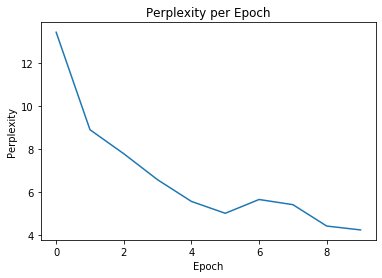

In [49]:

def plot_perplexity(perplexities):
    """plot perplexities"""
    plt.title("Perplexity per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.plot(perplexities)

plot_perplexity(dev_perplexities)


In [50]:
import sacrebleu

In [51]:
len(valid_data)

555

In [52]:
references = [" ".join(example.trg) for example in valid_data]

In [77]:
hypotheses = []
alphas = []  
for batch in valid_iter:
  batch = rebatch(PAD_INDEX, batch)
  pred, attention = greedy_decode(
    model, batch.src, batch.src_mask, batch.src_lengths, max_len=25,
    sos_index=TRG.vocab.stoi[SOS_TOKEN],
    eos_index=TRG.vocab.stoi[EOS_TOKEN])
  hypotheses.append(pred)
  alphas.append(attention)


In [78]:
hypotheses = [lookup_words(x, TRG.vocab) for x in hypotheses]

In [79]:
hypotheses = [" ".join(x) for x in hypotheses]

In [80]:
print(len(hypotheses))
print(hypotheses[2])

555
бір бүт ##ін он ##нан екі <unk> <unk> <unk> <unk>


In [81]:
bleu = sacrebleu.raw_corpus_bleu(hypotheses, [references], .01).score

In [82]:
print(bleu)

8.929048736931263


In [83]:
def plot_heatmap(src, trg, scores):

    fig, ax = plt.subplots()
    heatmap = ax.pcolor(scores, cmap='viridis')

    ax.set_xticklabels(trg, minor=False, rotation='vertical')
    ax.set_yticklabels(src, minor=False)

    # put the major ticks at the middle of each cell
    # and the x-ticks on top
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(scores.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(scores.shape[0]) + 0.5, minor=False)
    ax.invert_yaxis()

    plt.colorbar(heatmap)
    plt.show()


In [95]:
hypotheses[2]

'бір бүт ##ін он ##нан екі <unk> <unk> <unk> <unk>'

src ['1', ',', 'енді', 'бұл', 'екі', 'ортаға', 'жылдам', 'келді', '##к', '.', '.', '.', '</s>']
ref ['1', ',', 'енді', 'бұл', 'екі', 'ортаға', 'жылдам', 'келді', '##к', '</s>']
pred ['бір', 'бүт', '##ін', 'он', '##нан', 'екі', '<unk>', '<unk>', '<unk>', '<unk>', '</s>']


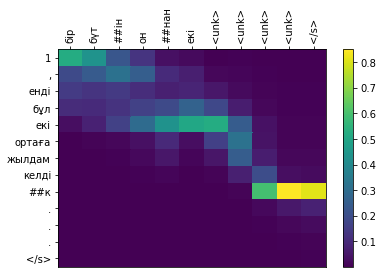

In [96]:
idx = 2
src = valid_data[idx].src + ["</s>"]
trg = valid_data[idx].trg + ["</s>"]
pred = hypotheses[idx].split() + ["</s>"]
pred_att = alphas[idx][0].T[:, :len(pred)]
print("src", src)
print("ref", trg)
print("pred", pred)
plot_heatmap(src, pred, pred_att)